# 14. QLS - Regression Model Instability

Regression analysis allows us to estimate coefficients in a function which relates multiple datasets. We hypothesise a specific form for this function and find coefficients that fit the data well, working under the assumption that deviations from the model are noise.

When building such models, we accept that it can't perfectly predict the dependent variable. Here, we'd like to evaluate the accuracy of the model; not by how well it explains the dependent variable, but by how *stable* the regression coefficients are with respect to our sample data. After all, if a model is a good fit, it should be similar for $n$ amount of data we model individually. Otherwise, we can't assume the model is a creation of the sample of data we've chosen, or that it will be predictive of new data points.

The same considerations apply for all regression models (not just linear regression). Below, we define a wrapper function for the linear regression from `statsmodels` for later use.

In [22]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sb
import statsmodels.api as sm
from statsmodels import regression, stats
import yfinance as yf

In [23]:
def linreg(x,y):
    # running the linear regression
    z = sm.add_constant(x) # add a row of 1s so the model has a constant term
    model = regression.linear_model.OLS(y, z).fit()
    return model.params[0], model.params[1] # return the coefficients of the linear model

## Biased Noise

The particular sample we choose for the data affects the model generated, and unevenly distributed noise can lead to an inaccurate model. Below we're drawing from a normal distribution, but because we don't have many data points, we get a significant downward bias. If we took more measurements,both of the regression coefficients would move toward zero.

Slope: 0.009072503822685526 Intercept: -0.40207744085303815


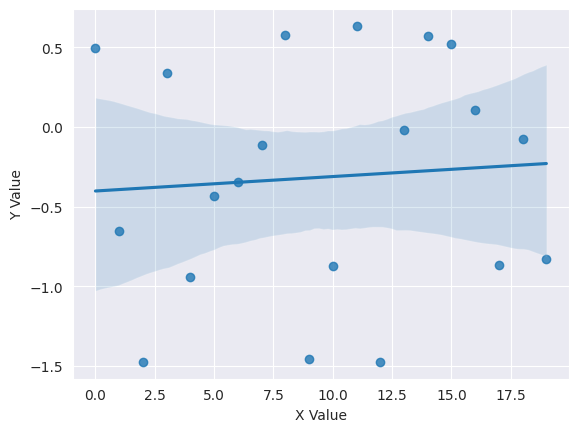

In [24]:
# draw observations from normal distribution
np.random.seed(107) # fix seed for random number generation
rand = np.random.randn(20)

# conduct linear regression on the ordered list of observations
xs = np.arange(20)
a, b = linreg(xs, rand)
print("Slope:", b, "Intercept:", a)

# plot the raw data and the regression line
sb.regplot(x=xs, y=rand).set(xlabel="X Value", ylabel="Y Value");

Slope: -0.0005693423631053362 Intercept: 0.009011767319021952


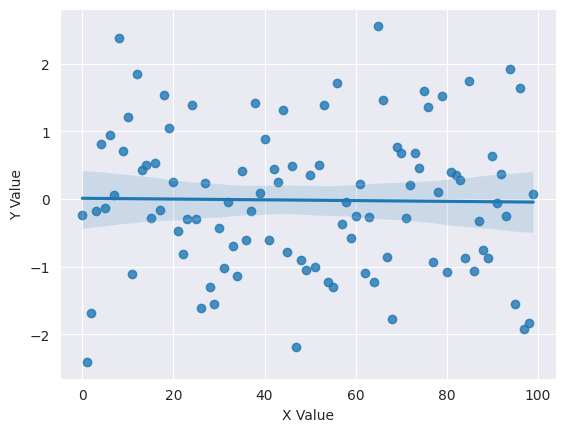

In [25]:
# draw more observations
rand2 = np.random.randn(100)

# conduct linear regression on the ordered list of observations
xs2 = np.arange(100)
a2, b2 = linreg(xs2, rand2)
print("Slope:", b2, "Intercept:", a2)

# plot the raw data and regression line
sb.regplot(x=xs2, y=rand2).set(xlabel="X Value", ylabel="Y Value");

Regression analysis is very sensitive to outliers. Sometimes they contain information, which we want to take into account; however, in cases like above, they can simply be random noise. Although we often have many more data points than above, we could have (e.g) fluctuations on the order of weeks or months, which change the regression coefficients.

## Regime changes

A structural break is when something changes in the data generating process, causing future samples to follow a different distribution. Below, we can see that there's a regime change at the end of 2007, and splitting the data results in a better fit (in red) than a regression on the whole data set (yellow). In this case, our regression model will not be predictive of future data points since the underlying process is not the same as in the sample. In fact, regression analysis assumes that the errors are uncorrelated and have constant variance, which won't be the case if there's a regime change.

[*********************100%***********************]  1 of 1 completed


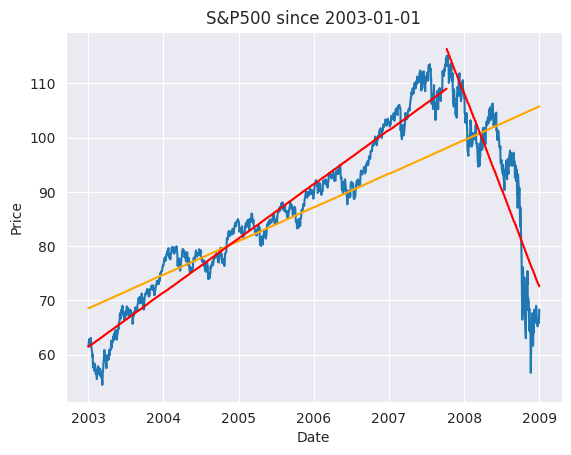

In [26]:
start = "2003-01-01"
end = "2009-01-01"
pricing = yf.download("SPY", start, end)
pricing1 = pricing["Adj Close"]

# manually set the point in which a structural break occurs
breakpoint2 = 1200
xs = np.arange(len(pricing1))
xs2 = np.arange(breakpoint2)
xs3 = np.arange(len(pricing1) - breakpoint2)

# perform linear regression on the full dataset, the data up the breakpoint, and the data after
a, b = linreg(xs, pricing1)
a2, b2 = linreg(xs2, pricing1[:breakpoint2])
a3, b3 = linreg(xs3, pricing1[breakpoint2:])

Y_hat = pd.Series(xs * b + a, index=pricing1.index)
Y_hat2 = pd.Series(xs2 * b2 + a2, index=pricing1.index[:breakpoint2])
Y_hat3 = pd.Series(xs3 * b3 + a3, index=pricing1.index[breakpoint2:])

# Plot the raw data
sb.lineplot(pricing1)
sb.lineplot(Y_hat, color="orange")
sb.lineplot(Y_hat2, color="red")
sb.lineplot(Y_hat3, color="red").set(title=f"S&P500 since {start}", xlabel="Date", ylabel="Price");

The more pieces we break our data into, the more precisely we can fit to it. It's important to avoid fitting to noise, which will always fluctuate and is not predictive. We can test for the existence of a regime change at a particular point, or in general. Below we use a test from `statsmodels` which computes the probability of observing the data if there's no breakpoint.

In [27]:
stats.diagnostic.breaks_cusumolsresid(regression.linear_model.OLS(pricing1, sm.add_constant(xs)).fit().resid)[1]

2.104343610056611e-52

## Multicollinearity

Above, we were only considering regressions of one dependent variable against an independent one. However, we can also have multiple independent variables. This leads to instability if the independent variables are highly correlated.

Imagine we are using two independent variables, $X_{1}$ and $X_{2}$, which are highly correlated. Then the coefficients may shift drastically if we add a new observation that is slightly better explained by one of the two than by the other. In the extreme case, if $X_{1} = X_{2}$, then the choice of coefficients will depend on the particular linear regression algorithm.

Below, we run a multiple linear regression in which the independent variables are highly correlated. If we take our sample period to be 2013 to 2015, then the coefficients are approximately $.25$ and $.1$. But if we extend the period to 2015-06-01, the coefficients become approximately $.18$ and $.20$, respectively.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Constant: -11.973520477829458
MLR beta to S&P500: 0.24150987378764677
MLR beta to MDY: 0.10949143868814187


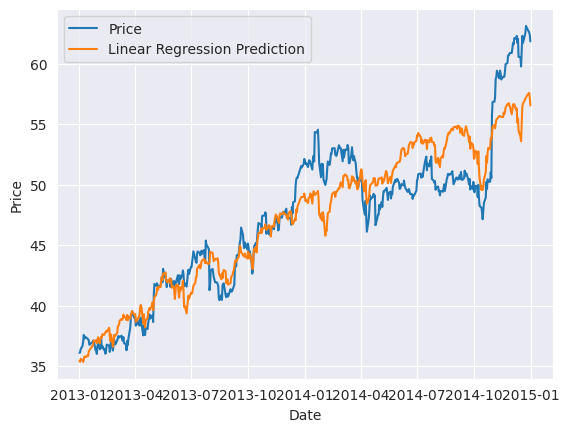

In [28]:
# get pricing data for two benchmark (indices) and a stock
start = "2013-01-01"
end = "2015-01-01"
b1 = yf.download("SPY", start, end)
b2 = yf.download("MDY", start, end)
asset = yf.download("V", start, end)

# select the adjusted close as the main data point.
b1 = b1["Adj Close"]
b2 = b2["Adj Close"]
asset = asset["Adj Close"]

mlr = regression.linear_model.OLS(asset, sm.add_constant(np.column_stack((b1, b2)))).fit()
prediction = mlr.params[0] + mlr.params[1]*b1 + mlr.params[2]*b2
print("Constant:", mlr.params[0])
print("MLR beta to S&P500:", mlr.params[1])
print("MLR beta to MDY:", mlr.params[2])

# plot the asset price data and the regression model's predictions
sb.lineplot(asset, label="Price")
sb.lineplot(prediction, label="Linear Regression Prediction").set(xlabel="Date", ylabel="Price");

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Constant: -22.184880975841576
MLR beta to S&P500: 0.20069629172922054
MLR beta to MDY: 0.19042126730468553


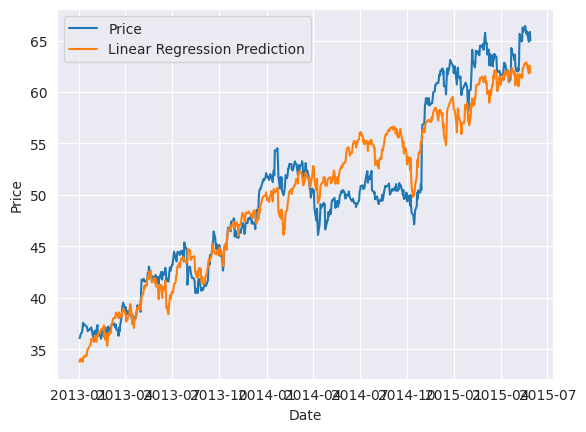

In [29]:
# get pricing data for two benchmark (indices) and a stock
start = "2013-01-01"
end = "2015-06-01"
b1 = yf.download("SPY", start, end)
b2 = yf.download("MDY", start, end)
asset = yf.download("V", start, end)

# select the adjusted close as the main data point.
b1 = b1["Adj Close"]
b2 = b2["Adj Close"]
asset = asset["Adj Close"]

mlr = regression.linear_model.OLS(asset, sm.add_constant(np.column_stack((b1, b2)))).fit()
prediction = mlr.params[0] + mlr.params[1]*b1 + mlr.params[2]*b2
print("Constant:", mlr.params[0])
print("MLR beta to S&P500:", mlr.params[1])
print("MLR beta to MDY:", mlr.params[2])

# plot the asset price data and the regression model's predictions
sb.lineplot(asset, label="Price")
sb.lineplot(prediction, label="Linear Regression Prediction").set(xlabel="Date", ylabel="Price");

We can check that our independent variables are correlated by computing their correlation coefficient (which lies between -1 and 1).

In [30]:
# compute Pearson correlation coefficient
sp.stats.pearsonr(b1, b2)[0] # second value is p-value

0.9898002368115473